## 1. Initial Setup and Library Imports

Importing all necessary libraries and setting up the environment for our analysis.

In [1]:
# --- Core Data Manipulation and NLP ---
import pandas as pd
import nltk
import numpy as np
import requests
nltk.download('vader_lexicon')
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# --- Data Visualization ---
import matplotlib.pyplot as plt

# --- Web Framework ---
from flask import Flask, render_template, request
import pandas as pd
import requests
from io import StringIO
nltk.download('punkt_tab')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jorda\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jorda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# 2. AFINN/Lexicon Loading
### Function to read and parse the AFINN lexicon, then loads it into a dictionary (afinn_dict)

In [2]:
'''
2. AFINN/Lexicon Loading
Function to read and parse the AFINN lexicon, then loads it into a dictionary (afinn_dict)
'''
def load_afinn_lexicon(afinn_path):
    afinn_dict = {} # initialise an empty dictionary to hold the AFINN lexicon
    try:
        with open(afinn_path, encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                word, score = line.rsplit('\t', 1)
                afinn_dict[word] = int(score)
    except FileNotFoundError:
        print(f"File not found: {afinn_path}")
    return afinn_dict


### Load the AFINN lexicon (provided sentiment dictionary) then print a sample of it

In [3]:
'''
Load the AFINN lexicon (provided sentiment dictionary) 
'''

afinn_path = "data/AFINN-en-165.txt"
afinn_dict = load_afinn_lexicon(afinn_path)

# print("AFINN dictionary loaded. Sample entries:")
# print(list(afinn_dict.items())[:10])  # show first 10 words and scores


# 3. Data Loading & Cleaning

Declare variable for sentiment analysis

Load dataset from github 

List special characters to be removed from dataset.

In [4]:
'''
3. Data Loading & Cleaning
'''
sid = SentimentIntensityAnalyzer()


# Load data
url = 'https://raw.githubusercontent.com/DyanelLancea/Airline-Review-Sentiement-Analysis/refs/heads/master/airlines_review.csv'
df = pd.read_csv(url)

# List of special characters to remove
removechar = [ '@', '#', '$', '%', '^', '&', '*', '(', ')',
               '-', '_', '=', '+', '{', '}', '[', ']', '|',
               '\\', ':', ';', '"', "'", '<', '>', '?',
                 '/', '~', '`', '✅ Trip Verified', 'Not Verified', 'Â Â', '✅ Verified Review']


Remove duplicates from dataset

Drop rows of data that have missing values

Replace mssing values with "NA" or "Unknown" if required

Function to remove sepcial characters from required column of data and tidy up for analysis

In [5]:

# Remove duplicates
df = df.drop_duplicates()
# Remove rows with missing values
df = df.dropna()

# Replace missing values with NA or Unknown function
def replace_missing_value(df):
    for col in df.columns:
        if df[col].dtype == 'O':  # Object type (string)
            df[col] = df[col].fillna('Unknown')
        else:
            df[col] = df[col].fillna("NA")
    return 

# Remove special characters from specific columns function
def remove_special_characters(df, removechar, char):
    for char in removechar:
        df['Airlines'] = df['Airlines'].str.replace(char, ' ', regex=False)
        df['Text Content'] = df['Text Content'].str.replace(char, '', regex=False)
    return df


Apply function replace missing values and remove speical characters

Standardize text case for analysis and make text lower case for analyzation

Remove unwanted leading spaces from all data column to make it neat and tidy

In [6]:

# Apply data cleaning functions
replace_missing_value(df)
remove_special_characters(df, removechar, char='')

# Standardize text case
df['Airlines'] = df['Airlines'].str.title()
df['Name'] = df['Name'].str.title()
df['Text Content Lower Case'] = df['Text Content'].str.lower()

# Remove leading spaces from the 'Name' column
df['Airlines'] = df['Airlines'].str.lstrip()
df['Name'] = df['Name'].str.lstrip()
df['Date Published'] = df['Date Published'].str.lstrip()
df['Text Content'] = df['Text Content'].str.lstrip()



Export cleaned data to "airlines_review_cleaned.csv" for analyzation function

In [7]:
# Save cleaned data to a new CSV file
df.to_csv('airlines_review_cleaned.csv', index=False)

# Display the cleaned DataFrame
#print(df)

## 4. Core Analysis Functions
### Function for Sentence tokanization 
This function takes some text and returns a list of sentences. If you don’t give it a string, it safely returns an empty list instead of crashing.

In [8]:
def tokenize_sentences(text):
    '''
    Function for Sentence tokanization. This function takes some text and returns a list of sentences. 
    If you don’t give it a string, it safely returns an empty list instead of crashing.
    '''
    if not isinstance(text, str):
        return []
    return sent_tokenize(text)

### Function to calculate sentiment and normalization

In [9]:
def calculate_sentiment_score(sentences, afinn_dict):
    '''
    Calculates the sentiment score
    '''
    score = 0
    words = sentences.lower().split()    # breaks down the sentence into individual words
    for word in words:  # goes through each word in the list 
        score += afinn_dict.get(word, 0)    # looks up each word and adds the score
    return score

def normalize_score(score, text_length):
    '''
    Calculates the normalization score
    '''
    if text_length == 0:    # sentences with no words will return a score of 0 (preventing an error of dividing by zero)
        return 0
    # normalization to get a score per word, then clamping to [-1, 1]
    normalized = score / text_length    # calculates the average score per word
    return max(-1.0, min(1.0, normalized))  
    # makes sure the score doesn't go over 1.0 and below -1.0. 
    # (if the score is -2.5, this will return -1.0)

### Function to find the extreme sentences

In [10]:
def find_extreme_sentences(sentences, afinn_dict):
    '''
    Finds extreme sentences with highest and lowest normalized sentiment scores
    1. Calculates sentiment scores for each sentence using the AFINN lexicon.
    2. Normalizes the sentiment scores based on sentence length.
    3. Identifies and returns the sentences with the highest and lowest normalized scores.
    '''
    
    if not sentences:   # to prevent errors if the list is empty
        return None, None

    # initialises an empty list to hold sentences and their scores
    scored_sentences = []
    for sent in sentences:
        score = calculate_sentiment_score(sent, afinn_dict)     # uses the sentiment score function
        normalized_score = normalize_score(score, len(sent.split()))    # uses the normalization function
        scored_sentences.append({'sentence': sent, 'score': normalized_score})

    # find the sentences with max and min normalized scores
    most_positive = max(scored_sentences, key=lambda x: x['score'])
    most_negative = min(scored_sentences, key=lambda x: x['score'])
    
    return most_positive, most_negative

### Sliding Window Function to find the most positive and negative paragraphs.

Using a window size lets us "slide" a focus area over the text. The window's score changes as it moves, so it can detect specific pockets of strong emotion(positive/negative).

When the window is over a section with very positive sentences, it will get a high score. When it slides over the negative section, it will get a very low score.

This give us a much more detailed and accurate picture of the sentiment throughout the text. It helps us pinpoint exactly where the most positive and negative opinions are located, rather than just getting a single, overall average.

In [11]:
def sliding_window_analysis_words(text, afinn_dict, window_size=10):
    """
    Applies a sliding window to find the most positive and negative text segments,
    based on a word-level window size.
    
    Args:
        text (str): The full text to analyze.
        afinn_dict (dict): The AFINN sentiment lexicon.
        window_size (int): The number of words to include in each window.

    Returns:
        tuple: A tuple containing the most positive and most negative paragraphs.
    """
    if not text:
        return None, None
        
    words = text.lower().split()
    if len(words) < window_size:
        return None, None
    
    scored_windows = []
    # Slide the window across the words
    for i in range(len(words) - window_size + 1):
        window = words[i:i + window_size]
        paragraph_text = ' '.join(window)
        
        # Calculate score for the paragraph window
        score = calculate_sentiment_score(paragraph_text, afinn_dict)
        normalized_score = normalize_score(score, len(paragraph_text.split()))

        scored_windows.append({'paragraph': paragraph_text, 'score': normalized_score})

    if not scored_windows:
        return None, None

    # Find the paragraphs with max and min scores
    most_positive_paragraph = max(scored_windows, key=lambda x: x['score'])
    most_negative_paragraph = min(scored_windows, key=lambda x: x['score'])
    
    return most_positive_paragraph, most_negative_paragraph



# 5. Apply Analysis to DataFrame

In [12]:
'''
Apply Analysis to DataFrame
'''
#Apply tonkenize function into Dataframe
df['Text Content Tokenized'] = df['Text Content'].apply(tokenize_sentences)

#Apply Sentiment scoring function into Dataframe
df['Sentiment Score'] = df.apply(lambda x: calculate_sentiment_score(x['Text Content'],afinn_dict), axis=1)

#Apply normalize function to Dataframe
df['Normalized Sentiment Score'] = df.apply(lambda x: normalize_score(x['Sentiment Score'],len(x["Text Content"].split())), axis=1)

#Apply finding extreme sentences function to Dataframe
df['Extreme Senctences'] = df.apply(lambda x: find_extreme_sentences(x['Text Content Tokenized'],afinn_dict), axis=1)

#Creating Columns for Most and Least Extreme Sentences
df['Most Positive Senctence'] = df['Extreme Senctences'].apply(lambda x: x[0]['sentence'])
df['Most Positive Senctence Score'] = df['Extreme Senctences'].apply(lambda x: x[0]['score'])
df['Most Negative Senctence'] = df['Extreme Senctences'].apply(lambda x: x[1]['sentence'])
df['Most Negative Senctence Score'] = df['Extreme Senctences'].apply(lambda x: x[1]['score'])

#Applying Sliding Window to Dataframe
df['Sliding Window Results'] = df.apply(lambda x: sliding_window_analysis_words(x['Text Content'],afinn_dict, window_size=10), axis=1)

#Creating Columns for Most Positive and Negative lines of words from sliding window analysis
df['Most Positive Line'] = df['Sliding Window Results'].apply(lambda x: x[0]['paragraph'])
df['Most Positive Line Score'] = df['Sliding Window Results'].apply(lambda x: x[0]['score'])
df['Most Negative Line'] = df['Sliding Window Results'].apply(lambda x: x[1]['paragraph'])
df['Most Negative Line Score'] = df['Sliding Window Results'].apply(lambda x: x[1]['score'])

#Output results into csv
df.to_csv('airlines_review_analysis.csv', index=False)


# 6. Evaluation Functions & Application
Model Evaulation: We shall be evaluating our sentiment analysis based on 4 metrics Accuracy, Precision, Recall and F1 Score.


In [13]:
'''
Evaluation Functions & Application
Model Evaulation: We shall be evaluating our sentiment analysis based on 4 metrics Accuracy, 
Precision, Recall and F1 Score.
'''
#Function to convert our analysis scores from numbers to postive or negative
def score_postive_negative(score):
    if score < -0:
        return "Negative"
    elif score >= 0:
        return "Postive"
    
#Function to chnage airline review ratings to postive or negative
def rating_postive_negative(rating):
    if rating <= 5:
        return "Negative"
    elif rating >= 6:
        return "Postive"

#Funtion to check if your analysis is True or False 
def determine_correct_prediction(actual, pred):
    if actual == pred:
        return True
    else:
        return False
    
#Function to calculate accuracy
def calculate_aaccuracy(whether_correct_pred):
    return sum(whether_correct_pred)/len(whether_correct_pred)

#Funtion to calculate confusion matrix
def calculate_confusion_matrix(actual, pred):
    if actual == 'Postive' and pred == 'Postive':
        return 'TP'
    elif actual == 'Negative' and pred == 'Postive':
        return 'FP'
    elif actual == 'Negative' and pred == 'Negative':
        return 'TN'
    elif actual == 'Postive' and pred == 'Negative':
        return 'FN'

#Function to calculate precision
def calculate_precision(confusion_matric):
    return confusion_matric.count('TP')/(confusion_matric.count('TP')+confusion_matric.count('FP'))

#Funtion to calculate Recall
def calculate_recall(confusion_matric):
    return confusion_matric.count('TP')/(confusion_matric.count('TP')+confusion_matric.count('FN'))

#Applying the all the functions to our datafraame
df['score_postive_negative'] = df.apply(lambda x: score_postive_negative(x['Normalized Sentiment Score']), axis=1)
df['rating_postive_negative'] = df.apply(lambda x: rating_postive_negative(x['Rating']), axis=1)
df['whether_correct_pred'] = df.apply(lambda x: determine_correct_prediction(x['rating_postive_negative'],x["score_postive_negative"]), axis=1)
df['confusion_matrix'] = df.apply(lambda x: calculate_confusion_matrix(x['rating_postive_negative'],x["score_postive_negative"]), axis=1)
recall = calculate_recall(df['confusion_matrix'].tolist())
precision = calculate_precision(df['confusion_matrix'].tolist())

#Funtion to Calculate F1 Score
def calculate_F1score(precision,recall):
    return 2 * (precision * recall) / (precision + recall)

#Print out the results
print('Accuracy of Sentiment Analysis is',calculate_aaccuracy(df['whether_correct_pred']))
print(f'Precision of Sentiment Analysis is {precision}')
print(f'Recall of Sentiment Analysis is {recall}')
print('F1 Score of Sentiment Analysis is',calculate_F1score(precision,recall))

Accuracy of Sentiment Analysis is 0.8044812133746984
Precision of Sentiment Analysis is 0.7771851851851852
Recall of Sentiment Analysis is 0.9313528228192686
F1 Score of Sentiment Analysis is 0.8473134489070744


Usually, sentiment classification of accuracy between 80 to 85% is a good benchmark. Therefore, we can say our analysis just about hits thaat mark at 80.4%. However, accuracy may not be the most aaccurate metric to test our analysis as it can be misledding for uneven datasets.

With a precision of 77.7%, the model correctly identified most of the reviews it labeled as positive. However, this also indicates that a small proportion of negative reviews were incorrectly predicted as positive which may be lead to some airlines getting better reviews than expected.

The recall score of 93.1% demonstrates that the model successfully identified the vast majority of actual positive reviews and would allow us to tell if the airline is truly good based on the reviews.

The F1 score of 84.7% provides a balanced measure of performance, reflecting the model’s ability to maintain both high recall and reasonable precision.


### Insights into our results

This calculates the mean normalized sentiment score for each airline and visualizes the results using a horizontal bar chart.

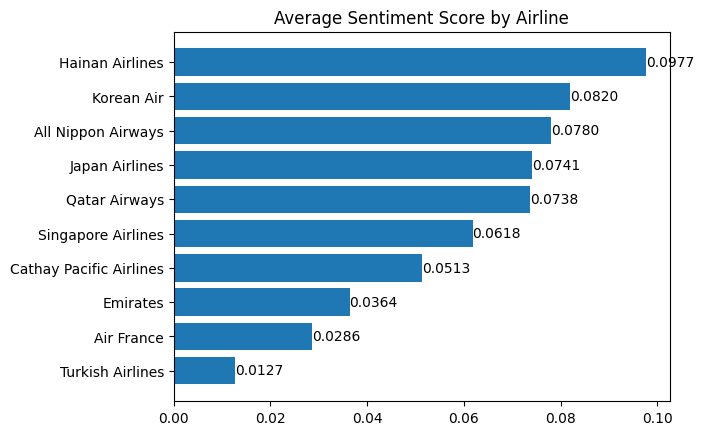

In [14]:
df_mean =  df.groupby('Airlines')['Normalized Sentiment Score'].agg('mean').sort_values() 

fig, ax = plt.subplots()

bx = ax.barh(df_mean.index, df_mean.values,label=df_mean.values)
ax.bar_label(bx, fmt='%.4f')
ax.set_title('Average Sentiment Score by Airline')

plt.show()

This generates a boxplot to compare the spread and distribution of normalized sentiment scores across different airlines.

Text(0.5, 1.0, 'Boxplot of Sentment Scores by Airline')

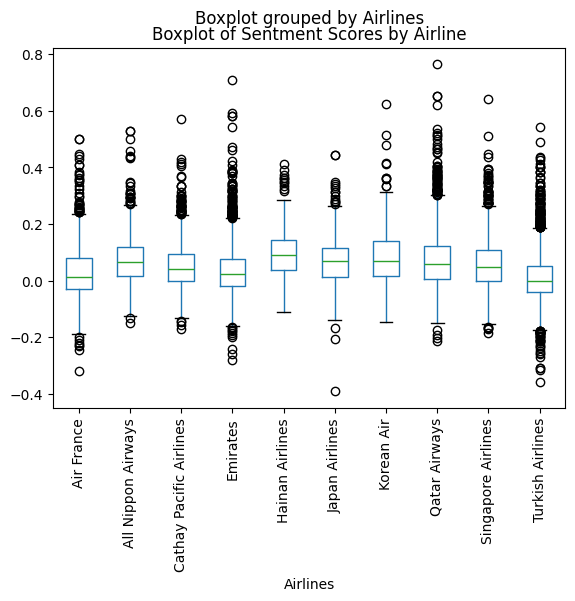

In [15]:
ax = df.boxplot(column='Normalized Sentiment Score',by='Airlines',rot=90,grid=False)
ax.set_title('Boxplot of Sentment Scores by Airline')

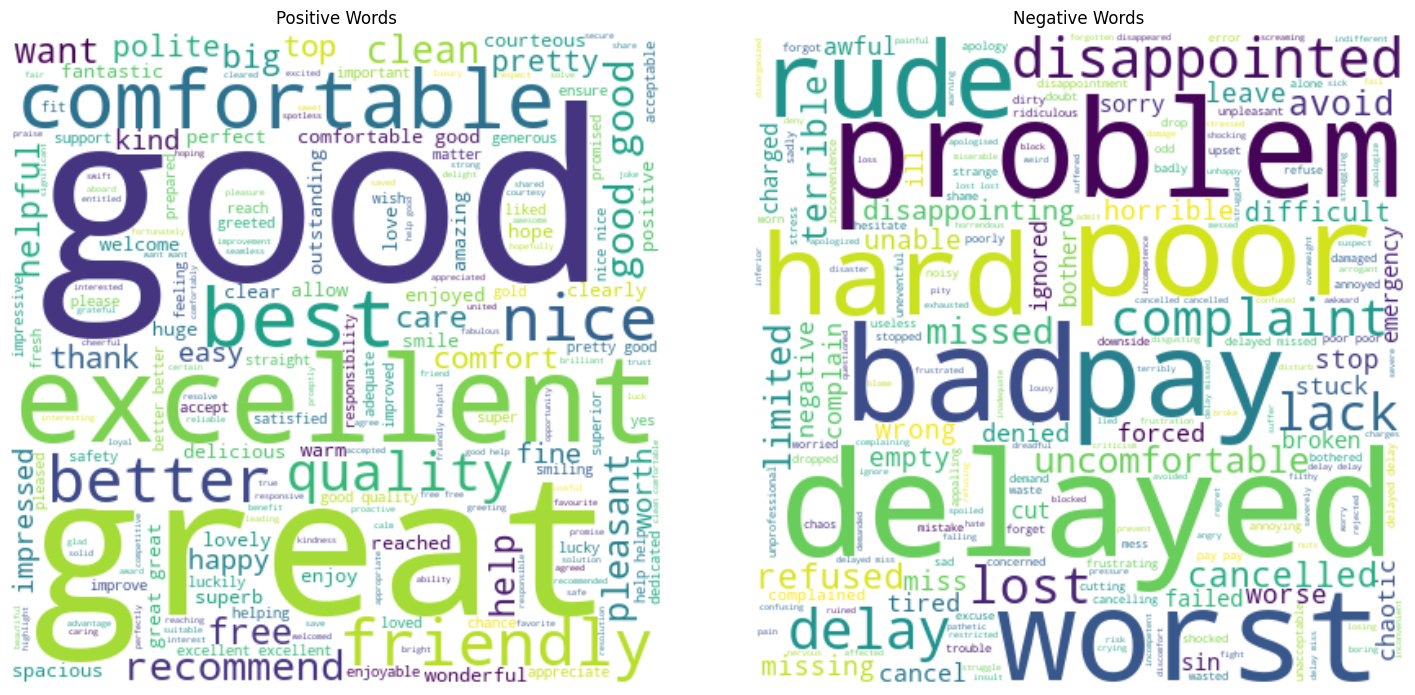

In [ ]:
from wordcloud import WordCloud

# Initialize lists to hold positive and negative words
positive_words = []
negative_words = []

# Iterate through each sentence in the DataFrame
for sentence in df['Text Content Lower Case']:
    words = sentence.split()  # Split sentence into words
    
    for word in words:
        score = afinn_dict.get(word, 0)  # Get the sentiment score of the word
        
        if score > 0:
            positive_words.append(word)  # Positive word
        elif score < 0:
            negative_words.append(word)  # Negative word

# Join the positive and negative words into single strings
positive_text = ' '.join(positive_words)
negative_text = ' '.join(negative_words)

# Create subplots for both positive and negative word clouds
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Create the positive word cloud
positive_wc = WordCloud(width=400, height=400, background_color="white").generate(positive_text)
axes[0].imshow(positive_wc, interpolation='bilinear')
axes[0].set_title("Positive Words")
axes[0].axis('off')

# Create the negative word cloud
negative_wc = WordCloud(width=400, height=400, background_color="white").generate(negative_text)
axes[1].imshow(negative_wc, interpolation='bilinear')
axes[1].set_title("Negative Words")
axes[1].axis('off')

plt.tight_layout()
plt.show()


### Arbitrary-Length Span

Find the most positive and most negative contiguous sentence spans (any length) and return the exact sentences that compose each span.

In [17]:
# ---------- NEW: helpers for arbitrary-length best segments (by sentences) ----------
from math import inf

def kadane_with_indices(arr):
    """Max subarray sum with start/end indices."""
    if not arr:
        return 0, -1, -1
    best_sum = -inf
    cur_sum = 0
    best_l = best_r = cur_l = 0
    for i, x in enumerate(arr):
        if cur_sum <= 0:
            cur_sum = x
            cur_l = i
        else:
            cur_sum += x
        if cur_sum > best_sum:
            best_sum, best_l, best_r = cur_sum, cur_l, i
    return best_sum, best_l, best_r

def best_sentence_span(text, afinn_dict):
    """
    Returns the most positive and most negative continuous sentence spans.
    Each span includes: text, score (sum), start index, end index, and the list of sentences.
    """
    sents = [s.strip() for s in sent_tokenize(text or "") if s.strip()]
    if not sents:
        return None, None

    # raw (unnormalized) AFINN sum per sentence
    sent_scores = [calculate_sentiment_score(s, afinn_dict) for s in sents]

    # most positive span
    pos_sum, pos_l, pos_r = kadane_with_indices(sent_scores)

    # most negative span = max subarray on negated scores, then flip sign back
    neg_sum_neg, neg_l, neg_r = kadane_with_indices([-x for x in sent_scores])
    neg_sum = -neg_sum_neg

    pos_span = {
        "text": " ".join(sents[pos_l:pos_r+1]),
        "score": float(pos_sum),
        "start": int(pos_l),
        "end": int(pos_r),
        "sentences": sents[pos_l:pos_r+1],
    }
    neg_span = {
        "text": " ".join(sents[neg_l:neg_r+1]),
        "score": float(neg_sum),
        "start": int(neg_l),
        "end": int(neg_r),
        "sentences": sents[neg_l:neg_r+1],
    }
    return pos_span, neg_span
# ---------- end helpers ----------

# 7. Web Application (Flask)

In [ ]:
app = Flask(__name__, template_folder='templates')

# URL of the CSV file
#url = 'https://raw.githubusercontent.com/DyanelLancea/Airline-Review-Sentiement-Analysis/refs/heads/master/airlines_review_analysis.csv'

# Fetch and load the CSV data
response = requests.get(url)
csv_data = StringIO(response.text)
#df = pd.read_csv(csv_data)

from nltk.tokenize import sent_tokenize

# Apply AFINN sentiment analysis
df["sentiment_score"] = df["Text Content Lower Case"].apply(
    lambda x: normalize_score(
        calculate_sentiment_score(str(x), afinn_dict),
        len(str(x).split())
    )
)

# Convert 'Date' column to datetime to facilitate month selection
df['Date Published'] = pd.to_datetime(df['Date Published'])

# Extract available airlines and months for the dropdowns
airlines = df['Airlines'].unique().tolist()
months = df['Date Published'].dt.month_name().unique().tolist()


@app.route('/', methods=['GET', 'POST'])
def index():
    selected_airline = None
    selected_month = None
    t_reviews = []
    b_reviews = []
    positive_window = None
    negative_window = None
    arb_pos = None
    arb_neg = None
    top_airlines = []  # For top airlines across all months
    top_airlines_month = []  # For top airlines based on the selected month


    if request.method == 'POST':
        selected_airline = request.form.get('airline')
        selected_month = request.form.get('month')

        # ** If "All" is selected, show top airlines across all months **
        if selected_month == 'All':
            # Calculate top 3 airlines across all months (no filtering by month)
            avg_scores_all = df.groupby('Airlines')['Normalized Sentiment Score'].mean()
            top_airlines = avg_scores_all.sort_values(ascending=False).head(3).items()

            # Show reviews for selected airline (if any)
            if selected_airline:
                filtered_df = df[df['Airlines'] == selected_airline]
            else:
                filtered_df = df  # Show all reviews if no specific airline is selected

        else:
            # ** If a specific month is selected, show reviews for that month **
            filtered_df = df[(df['Airlines'] == selected_airline) & 
                             (df['Date Published'].dt.month_name() == selected_month)]

            # Calculate top 3 airlines for the selected month
            monthly_data = df[df['Date Published'].dt.month_name() == selected_month]
            avg_scores_month = monthly_data.groupby('Airlines')['Normalized Sentiment Score'].mean()
            top_airlines_month = avg_scores_month.sort_values(ascending=False).head(3).items()

            # Show reviews for the selected airline (if any)
            if selected_airline:
                filtered_df = df[df['Airlines'] == selected_airline]

        # Sort reviews by sentiment score for top and bottom reviews
        top_reviews_df = filtered_df.sort_values(by='Sentiment Score', ascending=False)
        bottom_reviews_df = filtered_df.sort_values(by='Sentiment Score', ascending=True)

        top_reviews = top_reviews_df.head(3)
        bottom_reviews = bottom_reviews_df.head(3)

        t_reviews = top_reviews[['Most Positive Senctence', 'Sentiment Score']].values.tolist()
        b_reviews = bottom_reviews[['Most Negative Senctence', 'Sentiment Score']].values.tolist()

        # Sliding window analysis for positive and negative text segments
        all_text = ' '.join(filtered_df['Text Content'].dropna().astype(str).tolist())
        pos, neg = sliding_window_analysis_words(all_text, afinn_dict, window_size=10)

        positive_window = pos  # {'paragraph': ..., 'score': ...}
        negative_window = neg
  
    
    return render_template('index.html', airlines=airlines, months=months, t_reviews=t_reviews, b_reviews=b_reviews, selected_airline=selected_airline, selected_month=selected_month, positive_window=positive_window,
        negative_window=negative_window,pos_segment=arb_pos, neg_segment=arb_neg, top_airlines=top_airlines,
                                  top_airlines_month=top_airlines_month)

if __name__ == "__main__":
    app.run(debug=True, host='127.0.0.1', port=5002, use_reloader=False)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5002
Press CTRL+C to quit
